# Imports

In [2]:
import zipfile
import json
from scipy import sparse
import numpy as np
import time
import scipy.sparse.linalg as lg
import scipy.cluster.vq as vq
from matplotlib import pyplot as plt
%matplotlib inline  
import collections

# Dataset path

In [3]:
datadirectory="/home/leboudy/Downloads/lastfm_subset.zip"
dataset = zipfile.ZipFile(datadirectory)

# global variables initialization


In [4]:
songId=0
t=0
k=10
#g=50
#beta=0.2
#categories =["Technical Death Metal"]
#S =0#[]
#id2songJsonMap = []
id2songIdMap = {}
intId2SongStringID = {}
#fhat=[]
#n=5 #top songs to report
#limitingCounter = 1000
kmeansIterations=100

# Loading data


In [5]:
start_time = time.time()
for i in dataset.namelist():
    if  i.endswith(".json"): 
        f = json.loads(dataset.read(i).decode("utf-8"))
        if  f["track_id"] not in id2songIdMap.keys():
            id2songIdMap[f["track_id"]] = (songId,i)
            intId2SongStringID[songId] = i
            #tempcategories = set(categories)#will keep removing tags from it
            #newtags=[]
            #for tag in f["tags"]:#looping over tags
             #   if int(tag[1]) >g:#filters out those <g
              #      newtags.append(tag)#keeping >g
               #     if tag[0] in tempcategories:#if it is in the tempcategories
                #        tempcategories.remove(tag[0])#removing it
            #f["tags"] = newtags
            #id2songJsonMap.append(f)
            #songTags= [t[0] for t in f["tags"]]
            #if len(list(filter(lambda x: x in categories,songTags )) ) == len(categories):
            #if len(tempcategories)==0:#meaning we encountered all of the tags
             #   S+=1#.append(songId)
              #  fhat.append(1)
            #else:
             #   fhat.append(0)
            songId+=1 
            
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.4837961196899414 seconds ---


# initializing the teleportation probablilities


In [6]:
#_fhat=np.array()
#_fhat.shape=(songId,1)
#fhat=(1/len(S))*np.array(fhat)
#fhat=(1/S)*np.array(fhat)

# Building the Adjacency matrix


In [7]:
start_time = time.time()
col=[]
row=[]
data=[]
for i in id2songIdMap.keys():
    f = json.loads(dataset.read(id2songIdMap[i][1]).decode("utf-8"))
    for s in f["similars"]:
        if s[0] in id2songIdMap.keys() and s[1]>=t:
            #similar = json.loads(dataset.read(id2songIdMap[s[0]][1]).decode("utf-8"))
            val=s[1]
            #if i in similar["similars"].keys():
            #    val =max(val,similar["similars"][i])

                
            col.append(id2songIdMap[i][0])
            row.append(id2songIdMap[s[0]][0])
            data.append(val)
            
            #row.append(id2songIdMap[i][0])
            #col.append(id2songIdMap[s[0]][0])
            #data.append(val)
    
    
    

        
print("--- %s seconds ---" % (time.time() - start_time))        


--- 1.7544238567352295 seconds ---


In [8]:
A = sparse.csc_matrix((data, (row, col)),shape=(songId, songId))


In [9]:
print(A.shape)

(9330, 9330)


In [10]:
def maximum(A,B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data<0,1,0)
    return A-A.multiply(BisBigger)+B.multiply(BisBigger)

In [11]:
W = maximum(A,A.T)


In [12]:
W.shape

(9330, 9330)

# Unnoralised L

In [13]:
D = sparse.csc_matrix((list(W.sum(0).flat), (range(songId), range(songId))))

In [14]:
L=D-W

# Computing the Smallest K eignvectors

In [15]:
_,largestEigen,_= lg.svds(L,k=1)


In [16]:
I = sparse.identity(songId, format='csc')
I.setdiag(largestEigen[0])

In [17]:
largestEigen

array([ 12.63531276])

In [18]:
B = L-I

In [19]:
e,v= lg.eigs(B,k=k,return_eigenvectors=True ,which='LM')

In [20]:
e+=largestEigen


In [21]:
print(e.real)

[  4.56834510e-06   1.19469107e-06   1.77408604e-05   2.16712524e-05
   2.36332965e-05   2.55916674e-05   7.76907427e-11  -5.91526828e-13
   7.81597009e-12   3.85772508e-05]


In [22]:
print("Ratio Cut with constraints relaxation:")
print(e.sum())

Ratio Cut with constraints relaxation:
(0.000132977448619+0j)


In [23]:
c,l=vq.kmeans2(v.real,k,kmeansIterations)

/home/leboudy/anaconda2/envs/python3/lib/python3.5/site-packages/scipy/cluster/vq.py:653: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [24]:
rcut=0
for i in range(k):
    ciNodes = np.where(l==i)
    #print (len(ciNodes[0]))
    rcut+=(W[ciNodes[0],:].sum()/len(ciNodes[0]))
print ("The ratio cut according to the hard assignment is :")
print (rcut)
    
    
    

The ratio cut according to the hard assignment is :
2.26753751439


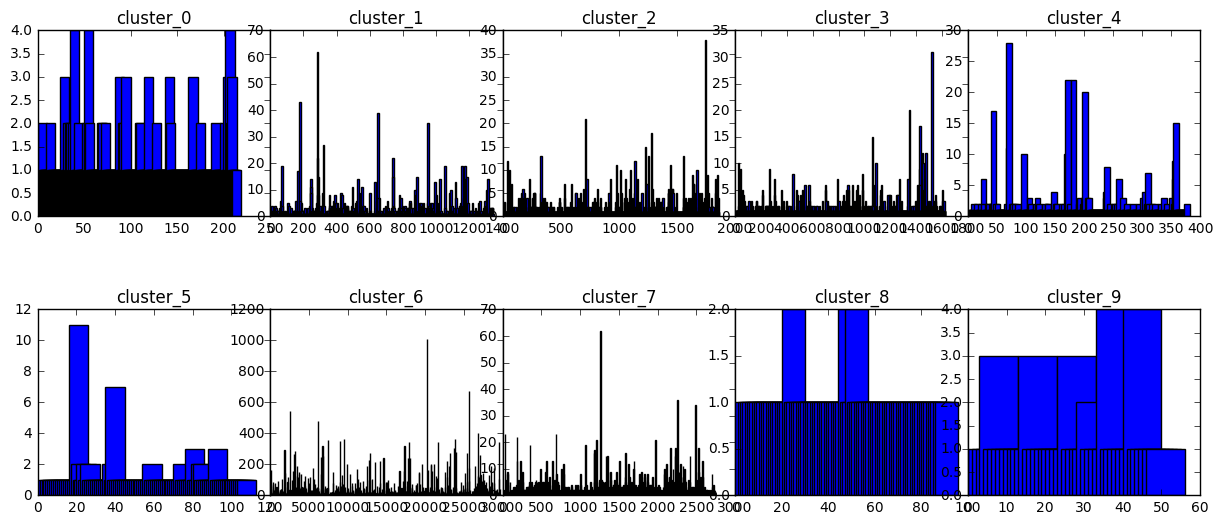

In [28]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()


for i in range(k):
    ciNodes = np.where(l==i)[0]
    tags=[]
    for n in ciNodes:
        f = json.loads(dataset.read(intId2SongStringID[n]).decode("utf-8"))
        if len(f['tags'])>0:
            tags.extend([x[0] for  x in f['tags'] ])
    
    tags= collections.Counter(tags)
    X = np.arange(len(tags))
    

    axs[i].bar(X, tags.values(), 10, color='b')
    axs[i].set_title("cluster_"+str(i))
    #p =plt.bar(X, tags.values(), 10, color='b')
    #plt.xticks(X, tags.keys())
    #print ("cluster:{}".format(i))

    #plt.show()

        
        

# Normalized L

In [ ]:
data = W.sum(0)
data[np.where(data!=0)] = 1/np.sqrt(data[np.where(data!=0)])
D_n = sparse.csc_matrix((list(data.flat), (range(songId), range(songId))))

In [ ]:
L_n = D_n.multiply(L.multiply(D_n))

In [ ]:
_,largestEigen_n,_= lg.svds(L_n,k=1)


In [ ]:
I_n = sparse.identity(songId, format='csc')
I_n.setdiag(largestEigen_n[0])

In [ ]:
B_n = L_n-I_n

In [ ]:
e_n,v_n= lg.eigs(B_n,k=,return_eigenvectors=True,which="LM")

In [ ]:
e_n

In [ ]:
print("Ratio Cut with constraints relaxation:")
print(e_n.sum())

In [ ]:
c_n,l_n=vq.kmeans2(v_n.real,k,kmeansIterations)